# 뉴스 카테고리 다중 분류

#### 목표

1. Vocabulary Size 변경해서 성능 비교하기
2. 다양한 모델 사용해서 성능 비교하기

#### 목차

1. [모든 단어 사용하기](#모든-단어-사용하기)

<hr>

In [126]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets import reuters

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

## 1. 모든 단어 사용하기

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


#### - 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


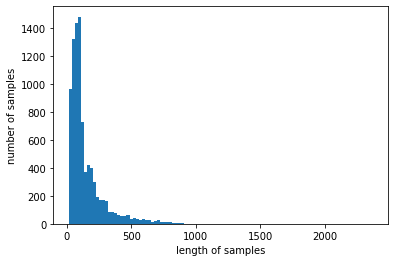

In [5]:
# 뉴스 길이 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

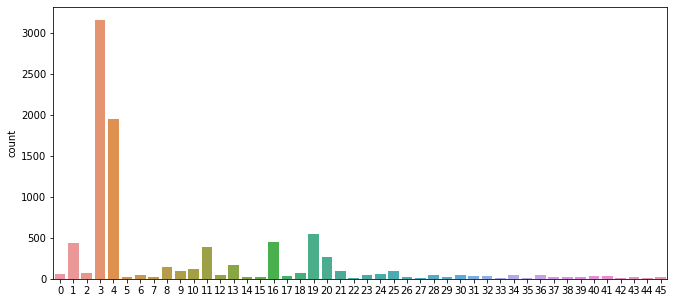

In [6]:
# 클래스 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

#### - 원본 뉴스 데이터로 복원

In [7]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

In [8]:
index_word = {index+3: word for word, index in word_index.items()}

In [9]:
# index_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_word[index] = token

In [10]:
# 뉴스 텍스트 복원
print(' '.join([index_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [11]:
# 훈련용 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

8982


In [12]:
# 테스트용 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


#### - 벡터화

In [13]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

# DTM 자체 규칙에 따라 불필요하다고 판단된 토큰들이 제거됨
print(x_train_dtm.shape)

(8982, 26506)


In [14]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

print(tfidfv.shape)

(8982, 26506)


In [15]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

#### - 모델 학습 및 예측

In [16]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [17]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


In [18]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [19]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7831700801424755


In [26]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [27]:
predicted = cb.predict(tfidfv_test)
print('정확도:', accuracy_score(y_test, predicted))

정확도: 0.7649154051647373


### - num_words=10000과의 비교

- 로지스틱 회귀: 정확도 0.8077 -> 0.8134
- 선형 서포트 벡터 머신: 정확도 0.7747 -> 0.7832
- CNB: 정확도 0.7707 -> 0.7649
- VotingClassifier 모델은 아래 에러가 발생해 수행할 수 없었다.
> valueerror: writebackifcopy base is read-only

<hr>

## 2. 상위 5000개 단어 사용하기

In [28]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [29]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

In [30]:
index_word = {index+3: word for word, index in word_index.items()}

In [31]:
# index_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_word[index] = token

In [32]:
# 훈련용 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

8982


In [33]:
# 테스트용 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [34]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

# DTM 자체 규칙에 따라 불필요하다고 판단된 토큰들이 제거됨
# column 개수가 num_words=5000보다 작음
print(x_train_dtm.shape)

(8982, 4867)


In [35]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

print(tfidfv.shape)

(8982, 4867)


In [36]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [37]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [38]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


In [39]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [40]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7689225289403384


In [43]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [44]:
predicted = cb.predict(tfidfv_test)
print('정확도:', accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


### - num_words=None과의 비교

- 로지스틱 회귀: 정확도 0.8134 -> 0.8059
- 선형 서포트 벡터 머신: 정확도 0.7832 -> 0.7689
- CNB: 정확도 0.7649 -> 0.7707
- VotingClassifier 모델은 아래 에러가 발생해 수행할 수 없었다.
> valueerror: writebackifcopy base is read-only

<hr>

## 3. 상위 15000개 단어 사용하기

In [45]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [46]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

In [47]:
index_word = {index+3: word for word, index in word_index.items()}

In [48]:
# index_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_word[index] = token

In [49]:
# 훈련용 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

8982


In [50]:
# 테스트용 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [51]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

# DTM 자체 규칙에 따라 불필요하다고 판단된 토큰들이 제거됨
# column 개수가 num_words=5000보다 작음
print(x_train_dtm.shape)

(8982, 14227)


In [52]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

print(tfidfv.shape)

(8982, 14227)


In [53]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [54]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [55]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8125556544968834


In [56]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [57]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7747105966162066


In [58]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [59]:
predicted = cb.predict(tfidfv_test)
print('정확도:', accuracy_score(y_test, predicted))

정확도: 0.7720391807658059


### - num_words=None과의 비교

- 로지스틱 회귀: 정확도 0.8134 -> 0.8125
- 선형 서포트 벡터 머신: 정확도 0.7832 -> 0.7747
- CNB: 정확도 0.7649 -> 0.772
- VotingClassifier 모델은 아래 에러가 발생해 수행할 수 없었다.
> valueerror: writebackifcopy base is read-only

- 결과적으로 가장 성능이 좋은 경우는 num_words=None일 때이다.

<hr>

## 4. 딥러닝 모델과 비교하기

- 딥러닝 모델에서는 경험상 vocab_size에 따른 성능 차이가 크게 나타나는데, 위 num_words에 따른 성능 차이가 크지 않았으므로 5000개 단어로 제한하여 진행하였다.

In [145]:
VOCAB_SIZE = 5000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=VOCAB_SIZE, test_split=0.2)

In [146]:
# 문장 길이 분포 확인
len_train = [len(s) for s in x_train]

print('최대 길이:', max(len_train))
print('평균 길이:', sum(len_train)//len(len_train))
print('최소 길이:', min(len_train))

최대 길이: 2376
평균 길이: 145
최소 길이: 13


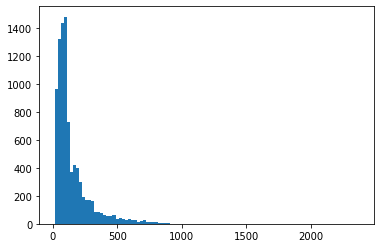

In [147]:
plt.hist(len_train, bins=100)
plt.show()

In [148]:
MAX_LEN = 400

final_x_train = []
final_y_train = []
final_x_test = []
final_y_test = []

for idx, sentence in enumerate(x_train):
    if len(sentence) <= MAX_LEN:
        final_x_train.append(sentence)
        final_y_train.append(y_train[idx])
        
for idx, sentence in enumerate(x_test):
    if len(sentence) <= MAX_LEN:
        final_x_test.append(sentence)
        final_y_test.append(y_test[idx])

In [149]:
print('x_train:', len(final_x_train))
print('y_train:', len(final_y_train))
print('x_test:', len(final_x_test))
print('y_test:', len(final_y_test))

x_train: 8400
y_train: 8400
x_test: 2085
y_test: 2085


In [150]:
final_x_train = pad_sequences(final_x_train, padding='post')
final_x_test = pad_sequences(final_x_test, padding='post')

print('x_train:', len(final_x_train))
print('x_test:', len(final_x_test))

x_train: 8400
x_test: 2085


In [151]:
final_x_train = np.array(final_x_train)
final_y_train = np.array(final_y_train)
final_x_test = np.array(final_x_test)
final_y_test = np.array(final_y_test)

In [152]:
final_y_train = to_categorical(final_y_train)
final_y_test = to_categorical(final_y_test)

In [199]:
WORD_VEC_DIM = 400

model = Sequential()
model.add(Embedding(VOCAB_SIZE, WORD_VEC_DIM))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(46, activation='softmax'))

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 400)         2000000   
_________________________________________________________________
lstm_28 (LSTM)               (None, 128)               270848    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 46)                5934      
Total params: 2,276,782
Trainable params: 2,276,782
Non-trainable params: 0
_________________________________________________________________


In [200]:
# callbacks
base_path = os.getenv('HOME') + '/aiffel/aiffel_projects/goingdeeper/GD4_reuters_classification/models'
checkpoint_path = base_path + '/wv400_do20_model.h5'

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(checkpoint_path, monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [201]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(final_x_train, final_y_train,
                    epochs=150,
                    batch_size=60,
                    callbacks=[es, mc],
                    verbose=1)

Epoch 1/150
140/140 [==============================] - 19s 128ms/step - loss: 2.6384 - accuracy: 0.3480

Epoch 00001: accuracy improved from -inf to 0.35440, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD4_reuters_classification/models/wv400_do20_model.h5
Epoch 2/150
140/140 [==============================] - 19s 132ms/step - loss: 2.3939 - accuracy: 0.3551

Epoch 00002: accuracy improved from 0.35440 to 0.36238, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD4_reuters_classification/models/wv400_do20_model.h5
Epoch 3/150
140/140 [==============================] - 18s 130ms/step - loss: 2.3954 - accuracy: 0.3703

Epoch 00003: accuracy improved from 0.36238 to 0.36714, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD4_reuters_classification/models/wv400_do20_model.h5
Epoch 4/150
140/140 [==============================] - 17s 124ms/step - loss: 2.4120 - accuracy: 0.3586

Epoch 00004: accuracy did not improve from 0.36714
Epoch 5/150
140/140 [====

In [202]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

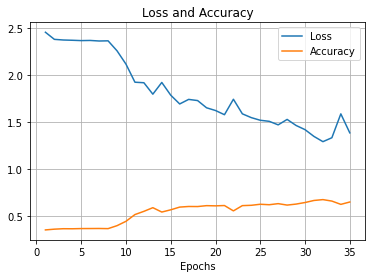

In [205]:
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, label='Loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, acc, label='Accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [204]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(final_x_test, final_y_test, verbose=1)

66/66 [==============================] - 2s 28ms/step - loss: 1.5313 - accuracy: 0.6158


## 결론 및 회고

- 머신러닝 중 로지스틱 회귀 모델을 이용한 정확도는 81%
- 딥러닝 중 LSTM 모델을 이용한 정확도는 62%
- 딥러닝 모델의 성능이 더 낮았다.
- 자연어 전처리와 토큰화 과정을 직접 다뤘다면 더 높은 성능이 나왔을 수도 있을 것 같다.